## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp016'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 448 #224
    tile_size = 448 #224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 448, 448])

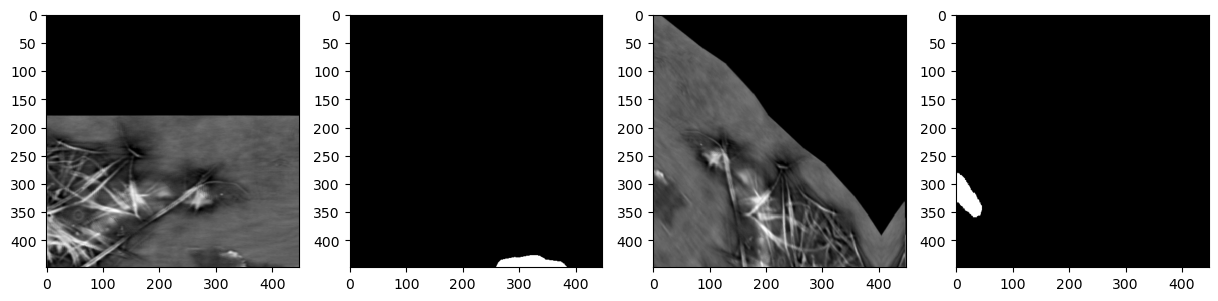

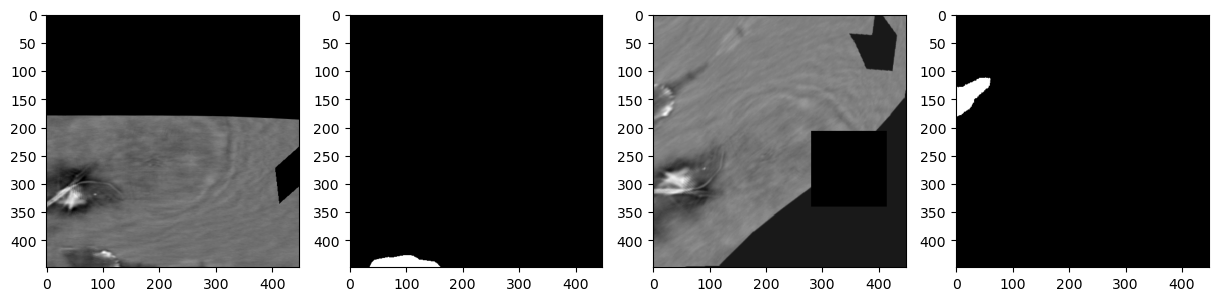

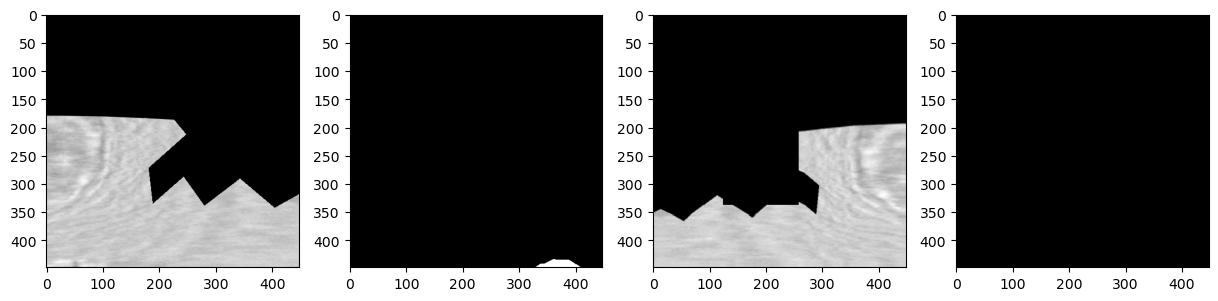

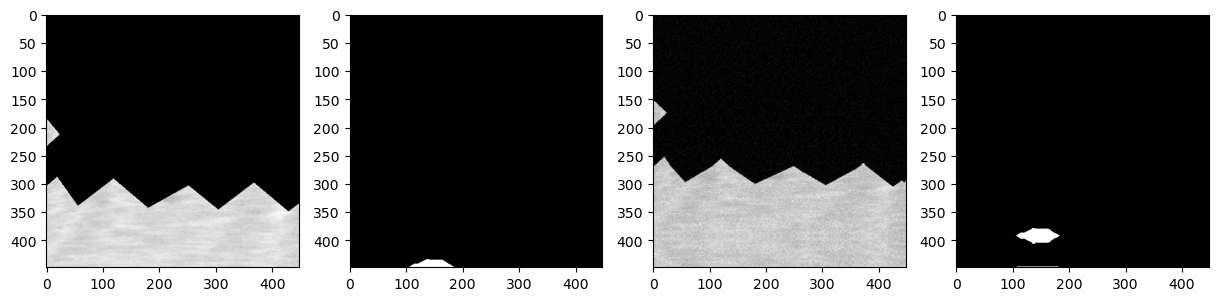

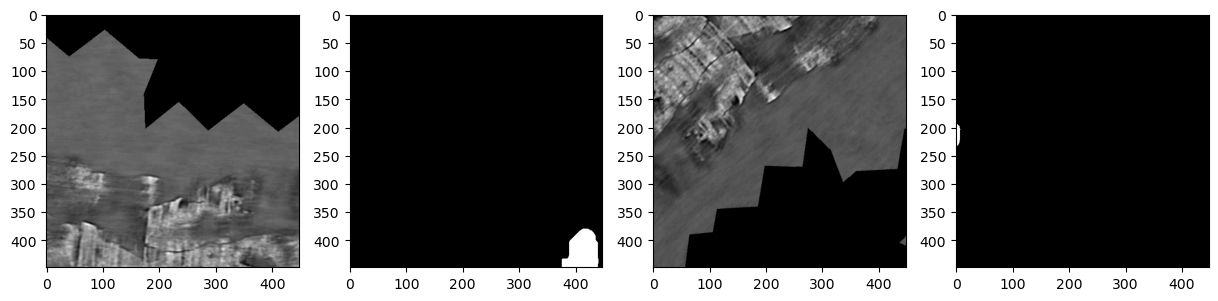

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48124

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.11517004335154916
th: 0.15, fbeta: 0.20329890064545258
th: 0.2, fbeta: 0.22429046367002278
th: 0.25, fbeta: 0.2373838834407268
th: 0.3, fbeta: 0.24926318721570176
th: 0.35, fbeta: 0.26455545918833917
th: 0.4, fbeta: 0.2831718099550673
th: 0.45, fbeta: 0.30365801179918234


best_th: 0.5, fbeta: 0.3190819822218125
Epoch 1 - avg_train_loss: 0.4778  avg_val_loss: 0.3655  time: 169s
Epoch 1 - avgScore: 0.3191
Epoch 1 - Save Best Score: 0.3191 Model
Epoch 1 - Save Best Loss: 0.3655 Model


th: 0.5, fbeta: 0.3190819822218125


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1155746009219446
th: 0.15, fbeta: 0.21663932692928559
th: 0.2, fbeta: 0.24309229198659216
th: 0.25, fbeta: 0.26802475530147174
th: 0.3, fbeta: 0.2957577279085359
th: 0.35, fbeta: 0.32963755563467045
th: 0.4, fbeta: 0.36627328059364656
th: 0.45, fbeta: 0.39915047369657725


best_th: 0.5, fbeta: 0.4176872035275135
Epoch 2 - avg_train_loss: 0.3925  avg_val_loss: 0.3280  time: 171s
Epoch 2 - avgScore: 0.4177
Epoch 2 - Save Best Score: 0.4177 Model
Epoch 2 - Save Best Loss: 0.3280 Model


th: 0.5, fbeta: 0.4176872035275135


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.29223325431889996
th: 0.15, fbeta: 0.3366437637271863
th: 0.2, fbeta: 0.37396197964020966
th: 0.25, fbeta: 0.40824623941160276
th: 0.3, fbeta: 0.440595980466262
th: 0.35, fbeta: 0.46708808940414165
th: 0.4, fbeta: 0.48474381133119476
th: 0.45, fbeta: 0.4965199153985116


best_th: 0.5, fbeta: 0.5050533965867426
Epoch 3 - avg_train_loss: 0.2924  avg_val_loss: 0.2339  time: 169s
Epoch 3 - avgScore: 0.5051
Epoch 3 - Save Best Score: 0.5051 Model
Epoch 3 - Save Best Loss: 0.2339 Model


th: 0.5, fbeta: 0.5050533965867426


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3125608917150811
th: 0.15, fbeta: 0.34057740699997185
th: 0.2, fbeta: 0.3662762922136901
th: 0.25, fbeta: 0.3920917296859594
th: 0.3, fbeta: 0.413716395560594
th: 0.35, fbeta: 0.4298122373082905
th: 0.4, fbeta: 0.44381832838149354
th: 0.45, fbeta: 0.44702435789052347


best_th: 0.45, fbeta: 0.44702435789052347
Epoch 4 - avg_train_loss: 0.2299  avg_val_loss: 0.2341  time: 170s
Epoch 4 - avgScore: 0.4470


th: 0.5, fbeta: 0.43635537587795054


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32477573270871957
th: 0.15, fbeta: 0.3490744420861229
th: 0.2, fbeta: 0.37028373933984393
th: 0.25, fbeta: 0.3920092562721326
th: 0.3, fbeta: 0.41103340410802625
th: 0.35, fbeta: 0.42489567249570614
th: 0.4, fbeta: 0.43376613185077295
th: 0.45, fbeta: 0.44135664519379336


best_th: 0.5, fbeta: 0.44727005280195287
Epoch 5 - avg_train_loss: 0.2035  avg_val_loss: 0.2449  time: 171s
Epoch 5 - avgScore: 0.4473


th: 0.5, fbeta: 0.44727005280195287


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40755924398546967
th: 0.15, fbeta: 0.4431684687466632
th: 0.2, fbeta: 0.46938298430291947
th: 0.25, fbeta: 0.48897625142254764
th: 0.3, fbeta: 0.5038776293483326
th: 0.35, fbeta: 0.5136937747834703
th: 0.4, fbeta: 0.5180356989850671
th: 0.45, fbeta: 0.5188353593324216


best_th: 0.45, fbeta: 0.5188353593324216
Epoch 6 - avg_train_loss: 0.1813  avg_val_loss: 0.2323  time: 171s
Epoch 6 - avgScore: 0.5188
Epoch 6 - Save Best Score: 0.5188 Model
Epoch 6 - Save Best Loss: 0.2323 Model


th: 0.5, fbeta: 0.5137442712071187


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47496149318114156
th: 0.15, fbeta: 0.4885831128969954
th: 0.2, fbeta: 0.4879675009332128
th: 0.25, fbeta: 0.48326206716642756
th: 0.3, fbeta: 0.47516759039027434
th: 0.35, fbeta: 0.4652599478552165
th: 0.4, fbeta: 0.44867733192990195
th: 0.45, fbeta: 0.42778396356328086


best_th: 0.15, fbeta: 0.4885831128969954
Epoch 7 - avg_train_loss: 0.1679  avg_val_loss: 0.2967  time: 170s
Epoch 7 - avgScore: 0.4886


th: 0.5, fbeta: 0.40491751236191104


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4238442378681517
th: 0.15, fbeta: 0.444532838046723
th: 0.2, fbeta: 0.4545679397645899
th: 0.25, fbeta: 0.463090376336256
th: 0.3, fbeta: 0.46757955659486705
th: 0.35, fbeta: 0.4653121291558999
th: 0.4, fbeta: 0.45990092136908356
th: 0.45, fbeta: 0.4523187136233192


best_th: 0.3, fbeta: 0.46757955659486705
Epoch 8 - avg_train_loss: 0.1523  avg_val_loss: 0.2747  time: 171s
Epoch 8 - avgScore: 0.4676


th: 0.5, fbeta: 0.4434122308169074


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.343645376076103
th: 0.15, fbeta: 0.3766429070039809
th: 0.2, fbeta: 0.4058951031439279
th: 0.25, fbeta: 0.4309408562871041
th: 0.3, fbeta: 0.4502719278470729
th: 0.35, fbeta: 0.4662023380051698
th: 0.4, fbeta: 0.480108807903243
th: 0.45, fbeta: 0.4900691165206878


best_th: 0.5, fbeta: 0.4966484359639654
Epoch 9 - avg_train_loss: 0.1419  avg_val_loss: 0.2374  time: 172s
Epoch 9 - avgScore: 0.4966


th: 0.5, fbeta: 0.4966484359639654


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34828382322574697
th: 0.15, fbeta: 0.37519322888838674
th: 0.2, fbeta: 0.396805834378
th: 0.25, fbeta: 0.4164045359873678
th: 0.3, fbeta: 0.4336452513722145
th: 0.35, fbeta: 0.4491883369097173
th: 0.4, fbeta: 0.46264993081956296
th: 0.45, fbeta: 0.47554422320198136


best_th: 0.5, fbeta: 0.4867712622325274
Epoch 10 - avg_train_loss: 0.1329  avg_val_loss: 0.2508  time: 171s
Epoch 10 - avgScore: 0.4868


th: 0.5, fbeta: 0.4867712622325274


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4362732778598279
th: 0.15, fbeta: 0.4615892439581885
th: 0.2, fbeta: 0.47941717104738274
th: 0.25, fbeta: 0.49646674671599744
th: 0.3, fbeta: 0.5094452490741771
th: 0.35, fbeta: 0.5176989573234307
th: 0.4, fbeta: 0.5217072353767087
th: 0.45, fbeta: 0.5197210959900752


best_th: 0.4, fbeta: 0.5217072353767087
Epoch 11 - avg_train_loss: 0.1186  avg_val_loss: 0.2701  time: 171s
Epoch 11 - avgScore: 0.5217
Epoch 11 - Save Best Score: 0.5217 Model
Epoch 11 - Save Best Loss: 0.2701 Model


th: 0.5, fbeta: 0.512974353070733


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41289959608137444
th: 0.15, fbeta: 0.4416595682305577
th: 0.2, fbeta: 0.463197999747854
th: 0.25, fbeta: 0.4794714623107981
th: 0.3, fbeta: 0.4916675538607324
th: 0.35, fbeta: 0.5014625624400938
th: 0.4, fbeta: 0.5087267770474978
th: 0.45, fbeta: 0.5125753933369521


best_th: 0.45, fbeta: 0.5125753933369521
Epoch 12 - avg_train_loss: 0.1118  avg_val_loss: 0.2542  time: 171s
Epoch 12 - avgScore: 0.5126


th: 0.5, fbeta: 0.5123114661870785


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42488306160380274
th: 0.15, fbeta: 0.4456579320673591
th: 0.2, fbeta: 0.45890242840278267
th: 0.25, fbeta: 0.46924670343710195
th: 0.3, fbeta: 0.48004460279840117
th: 0.35, fbeta: 0.48675631537505853
th: 0.4, fbeta: 0.4902282721547669
th: 0.45, fbeta: 0.49036930711940346


best_th: 0.45, fbeta: 0.49036930711940346
Epoch 13 - avg_train_loss: 0.1051  avg_val_loss: 0.2877  time: 171s
Epoch 13 - avgScore: 0.4904


th: 0.5, fbeta: 0.48830131229792045


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3963504552194757
th: 0.15, fbeta: 0.42411667380506657
th: 0.2, fbeta: 0.4481776398374956
th: 0.25, fbeta: 0.4668804826005473
th: 0.3, fbeta: 0.4836605954554153
th: 0.35, fbeta: 0.4983433333171023
th: 0.4, fbeta: 0.5096704710018988
th: 0.45, fbeta: 0.5185584298880543


best_th: 0.5, fbeta: 0.5250138421974284
Epoch 14 - avg_train_loss: 0.0975  avg_val_loss: 0.2680  time: 172s
Epoch 14 - avgScore: 0.5250
Epoch 14 - Save Best Score: 0.5250 Model
Epoch 14 - Save Best Loss: 0.2680 Model


th: 0.5, fbeta: 0.5250138421974284


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39483404160770647
th: 0.15, fbeta: 0.4144988761265976
th: 0.2, fbeta: 0.4306084999440079
th: 0.25, fbeta: 0.44551402553004593
th: 0.3, fbeta: 0.457733403807198
th: 0.35, fbeta: 0.4678822889055842
th: 0.4, fbeta: 0.47515504977577555
th: 0.45, fbeta: 0.4807559243441615


best_th: 0.5, fbeta: 0.4855303498163354
Epoch 15 - avg_train_loss: 0.0916  avg_val_loss: 0.2938  time: 171s
Epoch 15 - avgScore: 0.4855


th: 0.5, fbeta: 0.4855303498163354


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4260195086364412
th: 0.15, fbeta: 0.4505274681513917
th: 0.2, fbeta: 0.4732336432950383
th: 0.25, fbeta: 0.4922777639634369
th: 0.3, fbeta: 0.5070996981152509
th: 0.35, fbeta: 0.5189054982534367
th: 0.4, fbeta: 0.5267593844927803
th: 0.45, fbeta: 0.5313838598699049


best_th: 0.5, fbeta: 0.5330334143271647
Epoch 16 - avg_train_loss: 0.0850  avg_val_loss: 0.2881  time: 171s
Epoch 16 - avgScore: 0.5330
Epoch 16 - Save Best Score: 0.5330 Model
Epoch 16 - Save Best Loss: 0.2881 Model


th: 0.5, fbeta: 0.5330334143271647


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42715031764602296
th: 0.15, fbeta: 0.45658036977020733
th: 0.2, fbeta: 0.4794997186823917
th: 0.25, fbeta: 0.49741941409622725
th: 0.3, fbeta: 0.511358753588518
th: 0.35, fbeta: 0.5221095272321757
th: 0.4, fbeta: 0.5306661981627386
th: 0.45, fbeta: 0.5371393794583845


best_th: 0.5, fbeta: 0.5392473632490802
Epoch 17 - avg_train_loss: 0.0804  avg_val_loss: 0.2903  time: 171s
Epoch 17 - avgScore: 0.5392
Epoch 17 - Save Best Score: 0.5392 Model
Epoch 17 - Save Best Loss: 0.2903 Model


th: 0.5, fbeta: 0.5392473632490802


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4221447469860935
th: 0.15, fbeta: 0.44659663280952316
th: 0.2, fbeta: 0.46504817119064124
th: 0.25, fbeta: 0.47933166672228944
th: 0.3, fbeta: 0.4899681597089323
th: 0.35, fbeta: 0.4969475526461876
th: 0.4, fbeta: 0.5026312185262538
th: 0.45, fbeta: 0.5071805797783706


best_th: 0.5, fbeta: 0.5108216694332985
Epoch 18 - avg_train_loss: 0.0761  avg_val_loss: 0.3114  time: 171s
Epoch 18 - avgScore: 0.5108


th: 0.5, fbeta: 0.5108216694332985


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.442521055920649
th: 0.15, fbeta: 0.46769726997816474
th: 0.2, fbeta: 0.4849814185977938
th: 0.25, fbeta: 0.4979308515070957
th: 0.3, fbeta: 0.5077261861177368
th: 0.35, fbeta: 0.5148890467688813
th: 0.4, fbeta: 0.5195232385380528
th: 0.45, fbeta: 0.5235600677100052


best_th: 0.5, fbeta: 0.5273642884183765
Epoch 19 - avg_train_loss: 0.0722  avg_val_loss: 0.2971  time: 171s
Epoch 19 - avgScore: 0.5274


th: 0.5, fbeta: 0.5273642884183765


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42352114360029974
th: 0.15, fbeta: 0.4529574709877317
th: 0.2, fbeta: 0.4750512465051181
th: 0.25, fbeta: 0.492002662423183
th: 0.3, fbeta: 0.5051182072266864
th: 0.35, fbeta: 0.5164729189419126
th: 0.4, fbeta: 0.526709480822494
th: 0.45, fbeta: 0.5331724115638226


best_th: 0.5, fbeta: 0.535915849015984
Epoch 20 - avg_train_loss: 0.0682  avg_val_loss: 0.2829  time: 171s
Epoch 20 - avgScore: 0.5359


th: 0.5, fbeta: 0.535915849015984


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4731247126046154
th: 0.15, fbeta: 0.5002148260077584
th: 0.2, fbeta: 0.5189354232234671
th: 0.25, fbeta: 0.5318384683061271
th: 0.3, fbeta: 0.5406543875832487
th: 0.35, fbeta: 0.5459586783200259
th: 0.4, fbeta: 0.5482215715672385
th: 0.45, fbeta: 0.5478207024798937


best_th: 0.4, fbeta: 0.5482215715672385
Epoch 21 - avg_train_loss: 0.0654  avg_val_loss: 0.3081  time: 171s
Epoch 21 - avgScore: 0.5482
Epoch 21 - Save Best Score: 0.5482 Model
Epoch 21 - Save Best Loss: 0.3081 Model


th: 0.5, fbeta: 0.545106055853473


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.47132509720840643
th: 0.15, fbeta: 0.49590982377879284
th: 0.2, fbeta: 0.5123580540605654
th: 0.25, fbeta: 0.5223978553210608
th: 0.3, fbeta: 0.5295351722753127
th: 0.35, fbeta: 0.5344387570532699
th: 0.4, fbeta: 0.5374151720605601
th: 0.45, fbeta: 0.5387100629756358


best_th: 0.5, fbeta: 0.5388614548113627
Epoch 22 - avg_train_loss: 0.0625  avg_val_loss: 0.3406  time: 171s
Epoch 22 - avgScore: 0.5389


th: 0.5, fbeta: 0.5388614548113627


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4512325804406502
th: 0.15, fbeta: 0.47386946910036976
th: 0.2, fbeta: 0.4910997696527866
th: 0.25, fbeta: 0.5064249472071414
th: 0.3, fbeta: 0.5167052601955001
th: 0.35, fbeta: 0.5231706487848623
th: 0.4, fbeta: 0.5278319540674988
th: 0.45, fbeta: 0.5303315394474998


best_th: 0.45, fbeta: 0.5303315394474998
Epoch 23 - avg_train_loss: 0.0598  avg_val_loss: 0.3227  time: 170s
Epoch 23 - avgScore: 0.5303


th: 0.5, fbeta: 0.529998651806729


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4340036765577509
th: 0.15, fbeta: 0.4553532464583438
th: 0.2, fbeta: 0.4722252429325838
th: 0.25, fbeta: 0.48625458573670477
th: 0.3, fbeta: 0.4978027542445661
th: 0.35, fbeta: 0.5047066059055133
th: 0.4, fbeta: 0.5098029535945117
th: 0.45, fbeta: 0.5125834806416333


best_th: 0.5, fbeta: 0.5139301154710576
Epoch 24 - avg_train_loss: 0.0566  avg_val_loss: 0.3359  time: 170s
Epoch 24 - avgScore: 0.5139


th: 0.5, fbeta: 0.5139301154710576


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4652606695860405
th: 0.15, fbeta: 0.48883880461827983
th: 0.2, fbeta: 0.5058178531632973
th: 0.25, fbeta: 0.5197777533256419
th: 0.3, fbeta: 0.5291938962978185
th: 0.35, fbeta: 0.5350688881466729
th: 0.4, fbeta: 0.538402698263706
th: 0.45, fbeta: 0.5402887971561595


best_th: 0.5, fbeta: 0.5405806393666375
Epoch 25 - avg_train_loss: 0.0551  avg_val_loss: 0.3387  time: 171s
Epoch 25 - avgScore: 0.5406


th: 0.5, fbeta: 0.5405806393666375


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4744648012551724
th: 0.15, fbeta: 0.49471851832569674
th: 0.2, fbeta: 0.5104905517995806
th: 0.25, fbeta: 0.5217212888254067
th: 0.3, fbeta: 0.529027048947878
th: 0.35, fbeta: 0.5350308101336266
th: 0.4, fbeta: 0.5396295435392445
th: 0.45, fbeta: 0.5414423026098362


best_th: 0.5, fbeta: 0.5417230148912427
Epoch 26 - avg_train_loss: 0.0536  avg_val_loss: 0.3413  time: 171s
Epoch 26 - avgScore: 0.5417


th: 0.5, fbeta: 0.5417230148912427


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.477859616864188
th: 0.15, fbeta: 0.5014083258110665
th: 0.2, fbeta: 0.5192013726248046
th: 0.25, fbeta: 0.5311544406555785
th: 0.3, fbeta: 0.5397836552222222
th: 0.35, fbeta: 0.5457869142502972
th: 0.4, fbeta: 0.5492042062477588
th: 0.45, fbeta: 0.5508259961955569


best_th: 0.45, fbeta: 0.5508259961955569
Epoch 27 - avg_train_loss: 0.0532  avg_val_loss: 0.3387  time: 171s
Epoch 27 - avgScore: 0.5508
Epoch 27 - Save Best Score: 0.5508 Model
Epoch 27 - Save Best Loss: 0.3387 Model


th: 0.5, fbeta: 0.550608069643912


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4727409139915858
th: 0.15, fbeta: 0.4952665417839372
th: 0.2, fbeta: 0.511379555214544
th: 0.25, fbeta: 0.523931735108063
th: 0.3, fbeta: 0.5318745210345088
th: 0.35, fbeta: 0.534838696374562
th: 0.4, fbeta: 0.5357766159717098
th: 0.45, fbeta: 0.5354047812244391


best_th: 0.4, fbeta: 0.5357766159717098
Epoch 28 - avg_train_loss: 0.0513  avg_val_loss: 0.3438  time: 171s
Epoch 28 - avgScore: 0.5358


th: 0.5, fbeta: 0.5338482794633009


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4767564647091707
th: 0.15, fbeta: 0.498726736479795
th: 0.2, fbeta: 0.5138007845402294
th: 0.25, fbeta: 0.526062056873601
th: 0.3, fbeta: 0.5319553713776147
th: 0.35, fbeta: 0.5350307931581919
th: 0.4, fbeta: 0.5365289110972519
th: 0.45, fbeta: 0.5373641433373101


best_th: 0.45, fbeta: 0.5373641433373101
Epoch 29 - avg_train_loss: 0.0508  avg_val_loss: 0.3533  time: 171s
Epoch 29 - avgScore: 0.5374


th: 0.5, fbeta: 0.5357926810628528


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4688115387136461
th: 0.15, fbeta: 0.49146001596311517
th: 0.2, fbeta: 0.5068108877462281
th: 0.25, fbeta: 0.5169996467632229
th: 0.3, fbeta: 0.5231473984279046
th: 0.35, fbeta: 0.5266792125159321
th: 0.4, fbeta: 0.5290276460029226
th: 0.45, fbeta: 0.5309836889987162


best_th: 0.45, fbeta: 0.5309836889987162
Epoch 30 - avg_train_loss: 0.0514  avg_val_loss: 0.3525  time: 171s
Epoch 30 - avgScore: 0.5310


th: 0.5, fbeta: 0.5309590975773225


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.477859616864188
th: 0.15, fbeta: 0.5014083258110665
th: 0.2, fbeta: 0.5192013726248046
th: 0.25, fbeta: 0.5311544406555785
th: 0.3, fbeta: 0.5397836552222222
th: 0.35, fbeta: 0.5457869142502972
th: 0.4, fbeta: 0.5492042062477588
th: 0.45, fbeta: 0.5508259961955569


best_th: 0.45, fbeta: 0.5508259961955569


th: 0.5, fbeta: 0.550608069643912


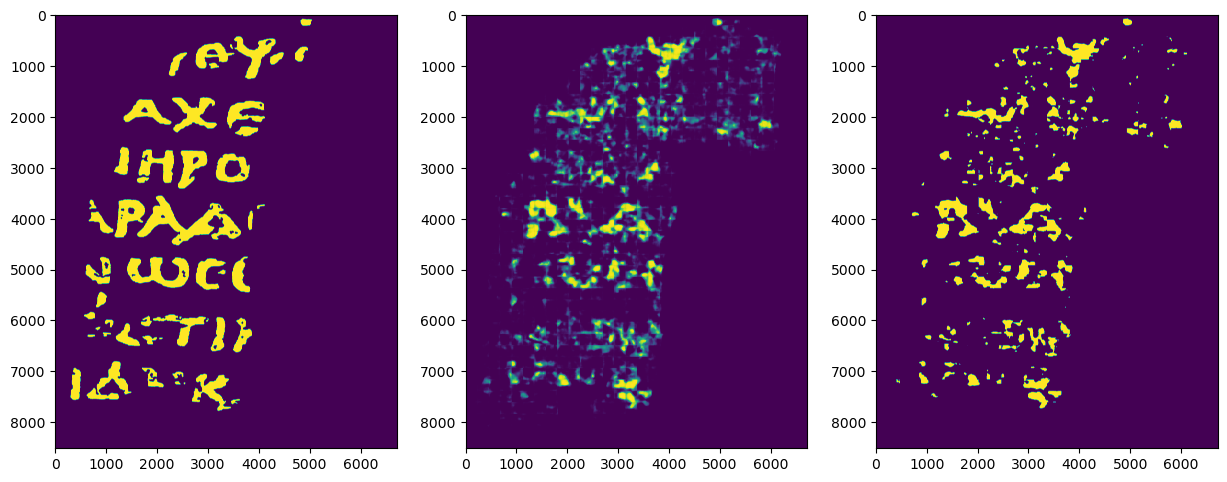

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([48723078.,  1714715.,  1022767.,   731697.,   562359.,   453653.,
          396908.,   346961.,   311615.,   281456.,   260088.,   222091.,
          197742.,   188263.,   182342.,   179824.,   191099.,   220065.,
          305677.,   708240.]),
 array([1.80087418e-05, 4.99823893e-02, 9.99467699e-02, 1.49911151e-01,
        1.99875531e-01, 2.49839912e-01, 2.99804292e-01, 3.49768673e-01,
        3.99733054e-01, 4.49697434e-01, 4.99661815e-01, 5.49626195e-01,
        5.99590576e-01, 6.49554957e-01, 6.99519337e-01, 7.49483718e-01,
        7.99448098e-01, 8.49412479e-01, 8.99376860e-01, 9.49341240e-01,
        9.99305621e-01]),
 <BarContainer object of 20 artists>)

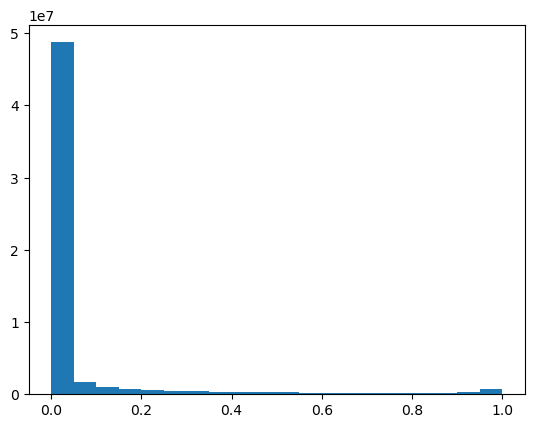

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000